### Step 1: Data Preprocessing and Loading

In [ ]:
import os
from PIL import Image
import numpy as np

# Define the path to the root directory where your data is stored
data_root = '/home/admin1/Downloads/Akash CJ/Dataset-20240111T132314Z-001/Dataset/Balanced dataset'

# Create empty lists to store images and labels
images = []
labels = []

# Define a dictionary to map folder names to class labels
class_mapping = {
    'Age-related macular degeneration (ARMD )': 0,
    'Branch retinal vein occlusion(BRVO)': 1,
    'Central retinal vein occlusion (CRVO)': 2,
    'Cotton wool spots (CWS)': 3,
    'Central serous retinopathy (CSR)' : 4,
    'Exudative detachment of the retina (EDN)': 5,
    'Microaneurysms (MCA)': 6,
    'Optic disc edema (ODE)' : 7,
    'Posterior retinal hemorrhage (PRH)' : 8,
    'Retinal hemorrhages (HR)' : 9,
    'Tortuous vessels (TV)' : 10,
    'Vitreous hemorrhage ( VH )' : 11


}

# Iterate through each folder in the root directory
for folder_name, class_label in class_mapping.items():
    folder_path = os.path.join(data_root, folder_name)

    # Iterate through each image file in the folder
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(folder_path, image_file)

            # Load and preprocess the image
            img = Image.open(image_path)
            img = img.resize((224, 224))  # Resize to a suitable input size
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

            # Append the preprocessed image and its label to the lists
            images.append(img)
            labels.append(class_label)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)


Explanation: In this step, we load and preprocess the dataset. We iterate through each class folder, read image files, resize them to a common size (224x224), and normalize the pixel values to the range [0, 1]. We also map folder names to class labels and store the images and labels in NumPy arrays.

### Step 2: Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Explanation: In this step, we split the data into training, validation, and testing sets using train_test_split from scikit-learn. Adjust the test sizes as needed.

### Step 3: Data Augmentation with Directory Structure (MobileNetV2)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your data directory
data_dir = '/home/admin1/Downloads/Akash CJ/Dataset-20240111T132314Z-001/Dataset/Balanced dataset'

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Create data generators with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into training and validation sets
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the training subset
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

# Load the pre-trained MobileNetV2 model without top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(12, activation='softmax')(x)  # 12 output classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)

# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Testing Accuracy:", test_acc)

# Save the model
model.save('MobileNet.h5')


2024-01-11 22:21:00.854854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 22:21:00.872361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:21:00.872377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:21:00.872905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 22:21:00.876472: I tensorflow/core/platform/cpu_feature_guar

Found 3766 images belonging to 12 classes.
Found 935 images belonging to 12 classes.


2024-01-11 22:21:17.667881: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
118/118 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.5879
Epoch 1: val_loss improved from inf to 1.03104, saving model to best_model.h5
118/118 [==============================] - 113s 948ms/step - loss: 1.2469 - accuracy: 0.5879 - val_loss: 1.0310 - val_accuracy: 0.6642
Epoch 2/20


/home/admin1/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7592
Epoch 2: val_loss improved from 1.03104 to 0.79083, saving model to best_model.h5
118/118 [==============================] - 109s 929ms/step - loss: 0.7039 - accuracy: 0.7592 - val_loss: 0.7908 - val_accuracy: 0.7326
Epoch 3/20
118/118 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7886
Epoch 3: val_loss did not improve from 0.79083
118/118 [==============================] - 109s 927ms/step - loss: 0.6136 - accuracy: 0.7886 - val_loss: 0.8177 - val_accuracy: 0.7765
Epoch 4/20
118/118 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.8237
Epoch 4: val_loss improved from 0.79083 to 0.74884, saving model to best_model.h5
118/118 [==============================] - 110s 930ms/step - loss: 0.5076 - accuracy: 0.8237 - val_loss: 0.7488 - val_accuracy: 0.7433
Epoch 5/20
118/118 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.8372
Epoch 5: va

In [ ]:
#pip install tensorflow

### Step 4 : Visualizing the learning of MobileNetV2 Architecture

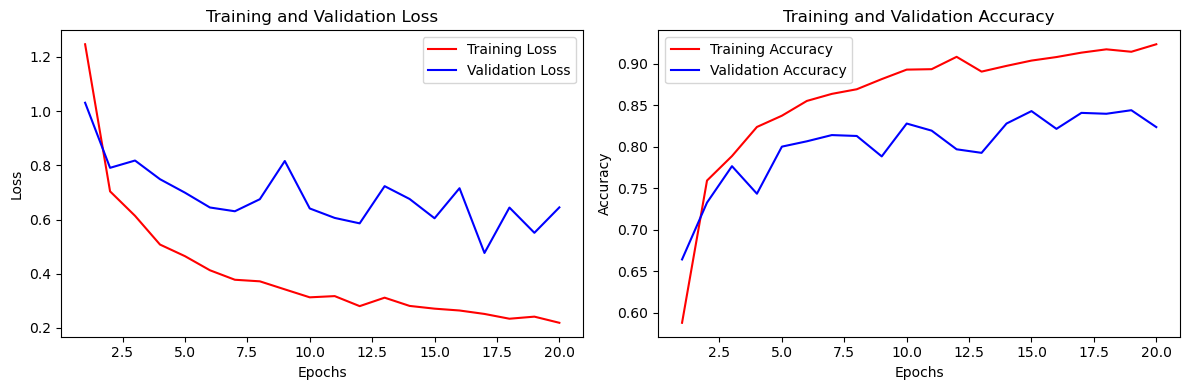

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#pip install tensorflow

### Step 5 : Testing

1/1 [==============================] - 1s 655ms/step
1.01206e-07


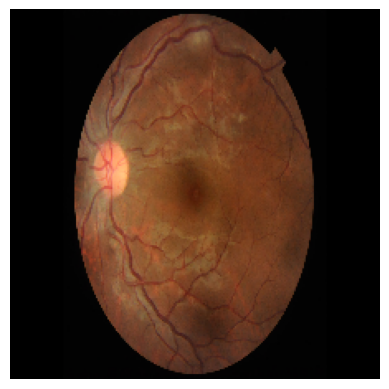

Image 399.png: Potential Risk of CVD .
1/1 [==============================] - 0s 40ms/step
1.0883361e-06


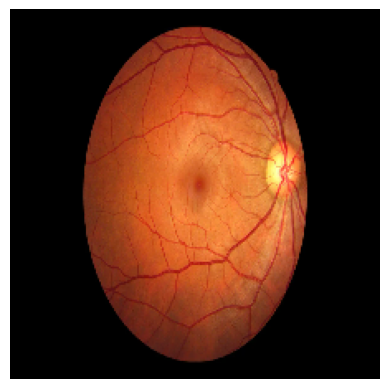

Image test1.png: No signs of CVD.
1/1 [==============================] - 0s 35ms/step
1.1023461e-10


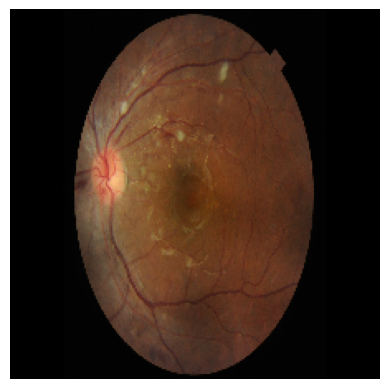

Image 132.png: Potential Risk of CVD .


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import time
import matplotlib.pyplot as plt

# Path to the folder containing your testing images
testing_dir = 'test/'

# Load the best-trained model
best_model = load_model('MobileNet.h5')

# Initialize an empty list to store the image file paths
image_paths = []

# Initialize a set to keep track of processed images to avoid duplication
processed_images = set()

# Define a threshold for classifying as CVD (you can adjust this threshold)
threshold = 5.986454840355e-07  # Adjust this value as needed

while True:
    # Get a list of all image files in the testing directory
    for filename in os.listdir(testing_dir):
        if filename.endswith(".png") and filename not in processed_images:
            image_path = os.path.join(testing_dir, filename)

            # Load and preprocess the image
            img = image.load_img(image_path, target_size=(224, 224))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img /= 255.0

            # Make predictions for the image
            prediction = best_model.predict(img)

            # Check if the predicted probability for CVD (index 2) is above the threshold
            is_cvd = prediction[0][2] <= threshold
            print(prediction[0][2])

            # Display the image
            plt.imshow(img[0])
            plt.axis('off')  # Hide axes
            plt.show()

            # Print the prediction result
            if is_cvd:
                print(f"Image {filename}: Potential Risk of CVD .")
            else:
                print(f"Image {filename}: No signs of CVD.")

            # Add the filename to the set of processed images
            processed_images.add(filename)

    # Sleep for a while to avoid continuously checking the folder
    time.sleep(5)  # Adjust the sleep duration as needed
